# 프로젝트5. FGSM 공격

- 적대적 예제(Adversarial Example) : 정상 이미지에 노이즈를 더해 머신러닝 모델을 헷갈리게 하는 이미지

- 사람 눈에는 똑같아 보이지만 적절한 잡음(노이즈)을 생성하여 머신러닝 모델이 헷갈리게 만드는 예제를 생성하여 공격

- 원본과 가장 적은 잡음을 찾아서 최적화하는 방식으로 '잡음'을 생성함

- FGSM(Fast Gradient Sign Method) : 반복 학습 없이 잡음을 생성하는 원샷 공격, 잡음이 눈에 보이지 않아야 하므로 아주 작은 숫자를 곱하여 희석한 후 원본 그림에 더하는 방식으로 공격

In [7]:
import torch

import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json

In [8]:
import matplotlib.pyplot as plt

# 학습된 모델 이용하기

- torchvision
- 다양한 미리 학습된 모델을 제공 : AlexNet, VGG, ResNet, SqueezeNet, DenseNet, Inception 등
- 컴퓨터 비전에 사용되는 컬러 이미지로 이루어진 이미지 데이터셋 이요

- 사용법 : models.<모델명> 함수, 인자 = pretrained = True

In [9]:
# 정확도를 올리려면, DenseNet, Inception v3 모델을 이용
# 노트북 등 성능이 떨어지는 환경 : SqueezeNet
# ResNet101도 괜찮음

model = models.resnet101(pretrained = True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 데이터셋 준비

- 결과는 0~1000 사이 숫자
- 숫자를 클래스 이름과 매칭 : imagenet_classes.json(숫자 + 클래스 이름)`

In [14]:
CLASSES = json.load(open('imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

# 이미지 불러오기

- 공격대상이 될 원본 이미지 불러오기
- 사용된 예제 이미지 파일 : shuna(슈나우저, 196번), chihuahua(치와와, 151번), corgie(웰시코기,263번)
- 인터넷에서 강아지 아무 사진 다운 받아 실행

- transform() 이용, 이미지넷과 같은 크기로 변환(224X224)
- unzqueeze()로 1차원 늘려줌

In [20]:
img = Image.open('schuna.jpg')

In [22]:
# 이미지를 텐서로 변환하기
img_transforms = transforms.Compose([
    transforms.Resize((224,224), Image.BICUBIC),
    transforms.ToTensor(),   
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print('Img Tensor :', img_tensor.size())

Img Tensor : torch.Size([1, 3, 224, 224])


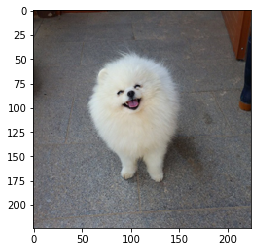

In [23]:
# 차원 늘려줬던 텐서를 넘파이 행렬로 변환 -> 맷플롯립과 호환 -> 이미지 시각화
# squeeze()로 차원을 줄임
# detach()로 원본 이미지 텐서와 연결 끊음

original_img_view = img_tensor.squeeze(0).detach() #[1,3,244,244] -> [3,244,244]
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()

#텐서 시각화
plt.imshow(original_img_view)

# 모델 성능 체크

 - 이미 학습된 모델(ResNet 101) 사용하므로 이미지를 모델에 통과시켜, 모델의 성능을 확인
 - max()함수 이용, 확률이 가장 높은 인덱스 = 예측값 이용

In [25]:
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print('predicted No.:', prediction_idx)
print('predicted Name:', prediction_name)

predicted No.: 258
predicted Name: Samoyed, Samoyede


# FGSM 공격함수

- 원리 : 모델에서 입력(원본) 이미지에 대한 기울기 정보를 추출 -> 왜곡 -> 원본에 더하여 속이기

- 학습 때와 반대로 모델의 오차값을 극대화 하기 위해 잡음이 기울기 방향으로 최적화하도록 설계

- 엡실론(epsilon) : 잡음이 '사람눈'에 보이지 않도록 아주 작은 숫자를 곱하여 희석한 후 원본에 더함

In [30]:
def fgsm_attack(image, epsilon, gradient) :
    # 기울기의 sign 값을 구함
    sign_gradient = gradient.sign()
    
    #이미지 각 필셀의 값을 sign_gradient 방향으로 epsilon만큼 조절
    # 엡실론 (epsilon)값은 아주 작은 값
    perturbed_image = image + epsilon * sign_gradient

    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# 적대적 공격 예제 생성
- requires_grad_(True) : 원본 이미지에 대한 기울기 추출하기 위함

In [31]:
# 원본 이미지의 기울기 구하기
img_tensor.requires_grad_(True)

# 이미지를 모델에 통과시켜 결과값 도출
output = model(img_tensor)

# '모델 성능 체크'에서 나온 이미지의 라벨 값을 이용하여 원본 이미지와 결과값의 오차 구하기
# 예: shuna(슈나우처, 196번) shihuahua(치와와, 151번) corgie(웰시코기, 263번)
loss = F.nll_loss(output, torch.tensor([196]))

# 기울기값 구하기
model.zero_grad()
loss.backward()

#이미지의 기울기값을 추출
gradient = img_tensor.grad.data

# FGSM 공격으로 적대적 예제 생성
# 엡실론 값은 0~1사이 여러 값으로 확인해보기
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

# 생성된 적대적 예제를 모델에 통과시킴
output = model(perturbed_data)



# 적대적 예제로 생성된 이미지로 모델 성능 확인
- 우리 눈에는 차이가 잘 보이지 않지만 모델은 다르게 판정

In [32]:
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print('predicted No:', perturbed_prediction_idx)
print('predicted Name:', perturbed_prediction_name)

predicted No: 279
predicted Name: Arctic fox, white fox, Alopex lagopus


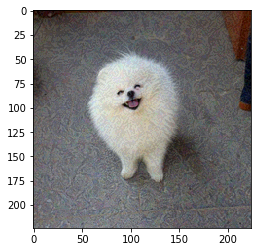

In [33]:
# 시각화를 위해 넘파이 행렬 변환

perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

# 원본과 적대적 예제 비교

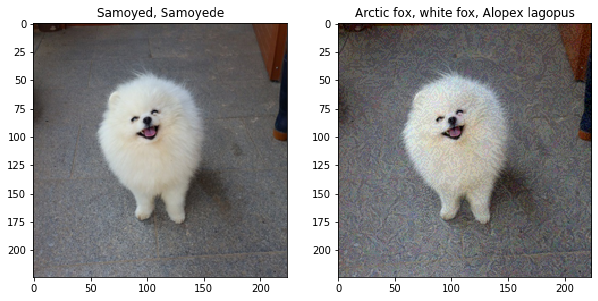

In [34]:
f, a = plt.subplots(1, 2, figsize=(10, 10))

# 원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

# 적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()